### Задание 1: Сделать базовый анализ данных: вывести размерность датасетов, посчитать базовые статистики, выполнить анализ пропусков, сделать выводы;





Ссылка на наборы данных: https://drive.google.com/file/d/1j8zuKbI-PW5qKwhybP4S0EtugbPqmeyX/view?usp=sharing


In [2]:
from typing import List, Optional
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns
import scipy.stats as st
from scipy.stats import probplot, ks_2samp

from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_is_fitted
import missingno as msno
import xgboost as xgb
%matplotlib inline

In [9]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")

print("train.shape = {} rows, {} cols".format(*train.shape))
print("test.shape = {} rows, {} cols".format(*test.shape))

train.shape = 200000 rows, 202 cols
test.shape = 200000 rows, 201 cols


In [4]:
train.describe()

,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,...,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,0.100490,10.679914,-1.627622,10.715192,6.796529,11.078333,-5.065317,5.408949,16.545850,0.284162,...,3.234440,7.438408,1.927839,3.331774,17.993784,-0.142088,2.303335,8.908158,15.870720,-3.326537
std,0.300653,3.040051,4.050044,2.640894,2.043319,1.623150,7.863267,0.866607,3.418076,3.332634,...,4.559922,3.023272,1.478423,3.992030,3.135162,1.429372,5.454369,0.921625,3.010945,10.438015
min,0.000000,0.408400,-15.043400,2.117100,-0.040200,5.074800,-32.562600,2.347300,5.349700,-10.505500,...,-14.093300,-2.691700,-3.814500,-11.783400,8.694400,-5.261000,-14.209600,5.960600,6.299300,-38.852800
25%,0.000000,8.453850,-4.740025,8.722475,5.254075,9.883175,-11.200350,4.767700,13.943800,-2.317800,...,-0.058825,5.157400,0.889775,0.584600,15.629800,-1.170700,-1.946925,8.252800,13.829700,-11.208475
50%,0.000000,10.524750,-1.608050,10.580000,6.825000,11.108250,-4.833150,5.385100,16.456800,0.393700,...,3.203600,7.347750,1.901300,3.396350,17.957950,-0.172700,2.408900,8.888200,15.934050,-2.819550
75%,0.000000,12.758200,1.358625,12.516700,8.324100,12.261125,0.924800,6.003000,19.102900,2.937900,...,6.406200,9.512525,2.949500,6.205800,20.396525,0.829600,6.556725,9.593300,18.064725,4.836800
max,1.000000,20.315000,10.376800,19.353000,13.188300,16.671400,17.251600,8.447700,27.691800,10.151300,...,18.440900,16.716500,8.402400,18.281800,27.928800,4.272900,18.321500,12.000400,26.079100,28.500700


In [5]:
train.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


In [11]:
numerical_features = train.select_dtypes(include=[np.number])

print(f"count of numeric_features {numerical_features.shape[1]}")
numerical_features.columns

count of numeric_features 201


Index(['target', 'var_0', 'var_1', 'var_2', 'var_3', 'var_4', 'var_5', 'var_6',
       'var_7', 'var_8',
       ...
       'var_190', 'var_191', 'var_192', 'var_193', 'var_194', 'var_195',
       'var_196', 'var_197', 'var_198', 'var_199'],
      dtype='object', length=201)

In [13]:
categorical_features = train.select_dtypes(include=[np.object])
print(f"Categorical Feature Count {categorical_features.shape[1]}")
categorical_features.tail(n=5)

Categorical Feature Count 1


,ID_code
199995,train_199995
199996,train_199996
199997,train_199997
199998,train_199998
199999,train_199999


In [23]:
discrete_feature = [
    feature for feature in numerical_features
    if len(train[feature].unique())<25
]

print(f"Discrete Variables Count: {len(discrete_feature)}")

Discrete Variables Count: 1


In [24]:
continuous_feature = [
    feature for feature in numerical_features
    if feature not in discrete_feature + ["ID_code"]]

print(f"Continuous Feature Count {len(continuous_feature)}")

Continuous Feature Count 200


Все признаки количественные, кроме одного - ID_code, но он не несет содержательной информации, лишь повторяет ID

<AxesSubplot:>

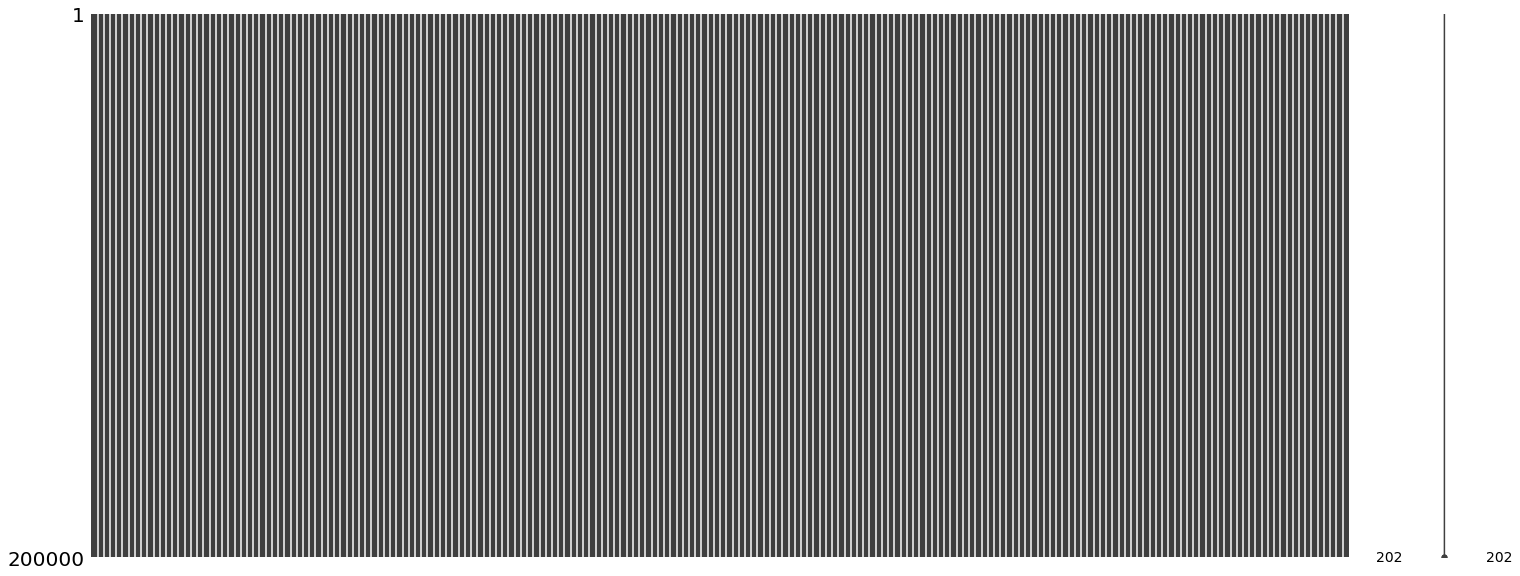

In [14]:
msno.matrix(train)

In [19]:
train.columns[train.isnull().any()]

Index([], dtype='object')

In [20]:
test.columns[test.isnull().any()]


Index([], dtype='object')

В трейне и тесте нет пропусков. 

### Задание 2: Сделать базовый анализ целевой переменной, сделать выводы;


In [21]:
train["target"].unique()


array([0, 1], dtype=int64)

In [22]:
train["target"].value_counts()


0    179902
1     20098
Name: target, dtype: int64

Целевая переменная бинарная. Сильно несбалансированная - 89% приходится на одно значение. 

### Задание 3: Построить распределение признаков в зависимости от значения целевой переменной и распределение признаков для обучающей и тестовой выборки (если машина не позволяет построить распределение для всех признаков, то выполнить задание для признаков var_0, var_1, var_2, var_5, var_9, var_10, var_13, var_20, var_26, var_40, var_55, var_80, var_106, var_109, var_139, var_175, var_184, var_196), сделать выводы;

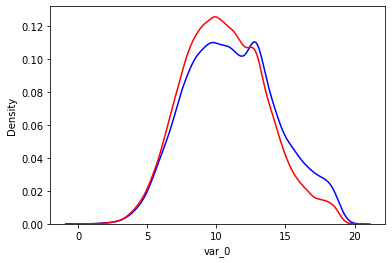

In [29]:
sns.kdeplot(train.loc[train['target']==1, 'var_0'], color="blue", label="target=1")
sns.kdeplot(train.loc[train['target']==0, 'var_0'], color="red", label="target=0")
plt.show()

In [31]:
features = ['var_0', 'var_1', 'var_2', 'var_5', 'var_9', 'var_10', 'var_13', 'var_20', 'var_26', 'var_40', 'var_55', 'var_80', 'var_106', 'var_109', 'var_139', 'var_175', 'var_184', 'var_196']

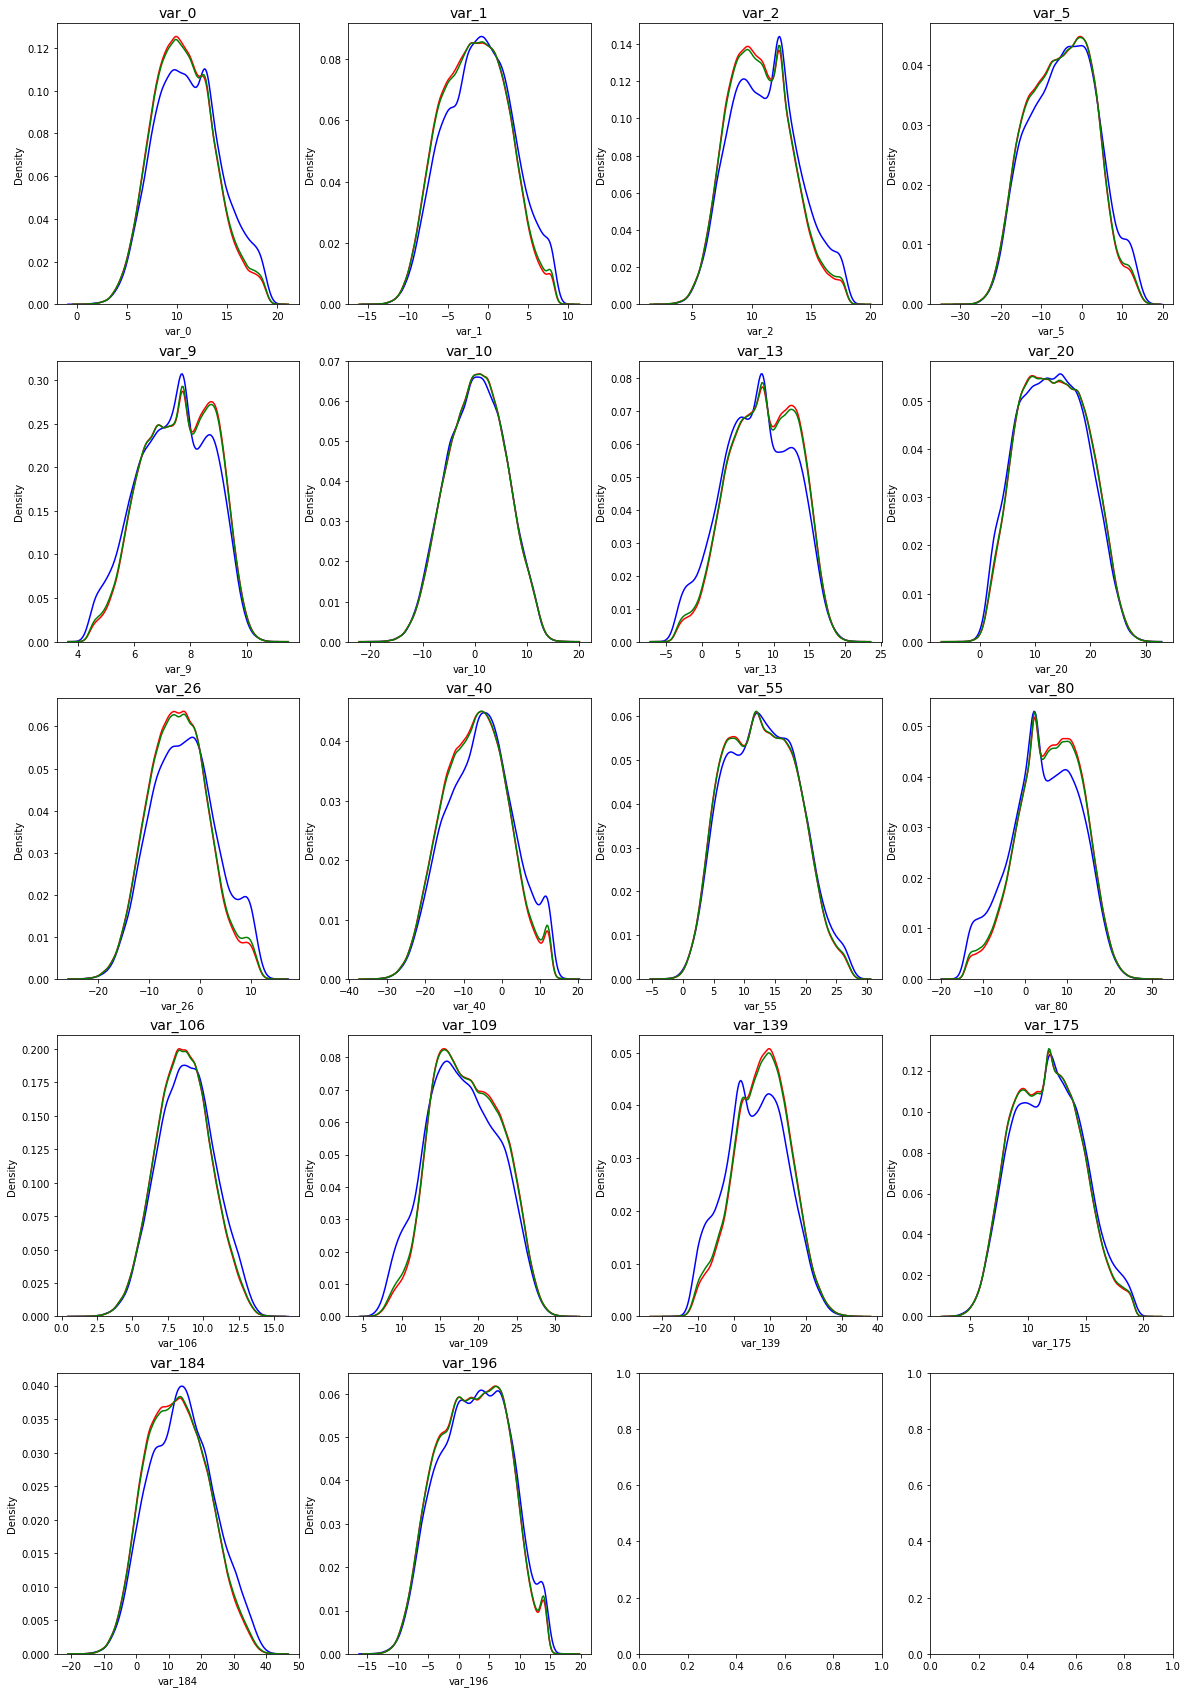

In [36]:
fig, axes = plt.subplots(5, 4, figsize=(20, 30))

for num, feature in enumerate(features):
    sns.kdeplot(train.loc[train['target']==1, feature], ax=axes[num//4, num%4], color="blue", label="target=1")
    sns.kdeplot(train.loc[train['target']==0, feature], ax=axes[num//4, num%4], color="red", label="target=0")
    sns.kdeplot(train[feature], ax=axes[num//4, num%4], color="green", label="train")
    axes[num//4, num%4].set_title(feature, fontsize=14)
plt.show()

Мы видим, что распределение на тесте почти совпадает с распределением переменной 0. Распределение 1 - значительно отличается. 


### Задание 4: Построить распределение основных статистики признаков (среднее, стандартное отклонение) в разрезе целевой переменной и распределение основных статистик обучающей и тестовой выборки, сделать выводы;

In [37]:
train.loc[train['target']==0, continuous_feature].describe()


,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,179902.000000,179902.000000,179902.000000,179902.000000,179902.000000,179902.000000,179902.000000,179902.000000,179902.000000,179902.000000,...,179902.000000,179902.000000,179902.000000,179902.000000,179902.000000,179902.000000,179902.000000,179902.000000,179902.000000,179902.000000
mean,10.626681,-1.695770,10.665876,6.788979,11.072412,-5.146736,5.389620,16.549306,0.262347,7.584907,...,3.149130,7.390800,1.949017,3.355403,18.017716,-0.155601,2.260297,8.919032,15.924058,-3.415273
std,3.008564,4.024813,2.612961,2.040082,1.620103,7.827522,0.857983,3.417700,3.331105,1.228839,...,4.522568,2.997847,1.476456,3.982819,3.127715,1.422275,5.441118,0.917467,2.978539,10.434525
min,0.408400,-15.043400,2.117100,-0.040200,5.074800,-32.562600,2.347300,5.349700,-10.505500,3.970500,...,-14.093300,-2.691700,-3.814500,-10.845500,8.694400,-5.261000,-14.209600,5.960600,6.299300,-38.852800
25%,8.429500,-4.790775,8.698025,5.247625,9.880600,-11.260950,4.756425,13.950125,-2.342575,6.637500,...,-0.111850,5.130825,0.915300,0.612400,15.656700,-1.178700,-1.987375,8.262100,13.896000,-11.312025
50%,10.478600,-1.682600,10.529000,6.817000,11.104400,-4.917700,5.364400,16.460850,0.371400,7.645600,...,3.117250,7.297000,1.928950,3.417550,17.982400,-0.184200,2.359700,8.897700,15.988500,-2.914000
75%,12.693075,1.287700,12.463900,8.317875,12.253100,0.844600,5.981300,19.108800,2.919300,8.598075,...,6.296375,9.461300,2.969800,6.217075,20.417500,0.813000,6.513425,9.601500,18.095400,4.741400
max,20.315000,10.376800,19.353000,13.188300,16.671400,17.251600,8.447700,27.691800,10.151300,11.150600,...,18.440900,16.716500,8.402400,18.281800,27.928800,4.272900,18.321500,12.000400,26.079100,28.500700


In [38]:
train.loc[train['target']==1, continuous_feature].describe()


,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,20098.000000,20098.000000,20098.000000,20098.000000,20098.000000,20098.000000,20098.000000,20098.000000,20098.000000,20098.000000,...,20098.000000,20098.000000,20098.000000,20098.000000,20098.000000,20098.000000,20098.000000,20098.000000,20098.000000,20098.000000
mean,11.156418,-1.017613,11.156633,6.864113,11.131337,-4.336522,5.581966,16.514917,0.479432,7.409064,...,3.998064,7.864560,1.738266,3.120260,17.779568,-0.021130,2.688583,8.810815,15.393283,-2.532243
std,3.270293,4.220638,2.841075,2.070898,1.649266,8.140281,0.922442,3.421365,3.340028,1.278709,...,4.814830,3.210779,1.482537,4.067550,3.193153,1.485975,5.556892,0.952554,3.248123,10.435910
min,0.452800,-14.037000,2.946200,0.374000,5.876200,-28.246100,2.496000,7.302400,-9.839100,4.186100,...,-11.906900,-2.343000,-3.317700,-11.783400,10.120700,-5.018500,-14.020400,6.119000,6.558700,-38.852800
25%,8.695875,-4.203475,8.961125,5.314300,9.911250,-10.615800,4.882250,13.880125,-2.107425,6.451575,...,0.466025,5.418550,0.669775,0.343000,15.420025,-1.103950,-1.572225,8.155250,13.232500,-10.285050
50%,11.001350,-0.992650,11.096700,6.900200,11.156300,-4.101950,5.601800,16.412700,0.579600,7.484950,...,4.017500,7.846550,1.667500,3.176700,17.730500,-0.057350,2.831050,8.795400,15.427950,-1.971850
75%,13.343700,2.001375,13.047025,8.384725,12.328450,1.619950,6.218550,19.044250,3.127825,8.437200,...,7.407925,10.018400,2.749050,6.063825,20.201800,0.986450,6.956250,9.517000,17.776425,5.701475
max,19.458300,9.029800,18.294100,12.706900,15.692500,16.423600,8.285200,27.039800,9.033000,10.588100,...,16.746100,16.520500,7.647600,17.150400,27.295300,4.088100,17.161400,11.706900,25.857100,24.564600


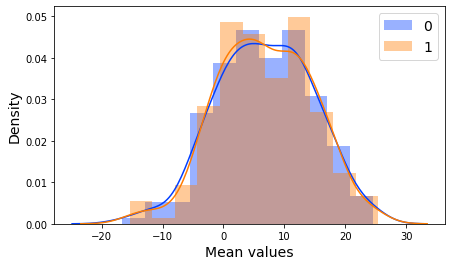

In [43]:
var_target_0 = train.loc[train['target'] == 0, continuous_feature].mean().values.flatten()
var_target_1 = train.loc[train['target'] == 1, continuous_feature].mean().values.flatten() 

plt.figure(figsize=(7, 4))
sns.set_palette("bright")
sns.distplot(var_target_0, label='0')
sns.distplot(var_target_1, label='1')

plt.xlabel('Mean values', size=14)
plt.legend(loc="best", fontsize=14)
plt.ylabel("Density", size=14)
plt.show()

Распределение средних имеет примерно одну форму, однако все же заметно отличается

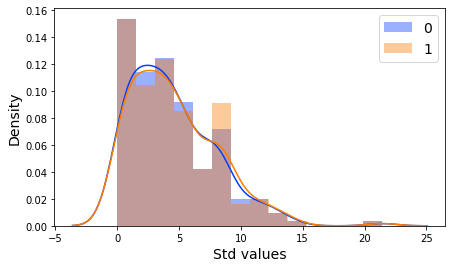

In [44]:
var_target_0 = train.loc[train['target'] == 0, continuous_feature].std().values.flatten()
var_target_1 = train.loc[train['target'] == 1, continuous_feature].std().values.flatten() 

plt.figure(figsize=(7, 4))
sns.set_palette("bright")
sns.distplot(var_target_0, label='0')
sns.distplot(var_target_1, label='1')

plt.xlabel('Std values', size=14)
plt.legend(loc="best", fontsize=14)
plt.ylabel("Density", size=14)
plt.show()

Распределение отклонений также имеет схожую форму, но есть несколько заметных различий. 

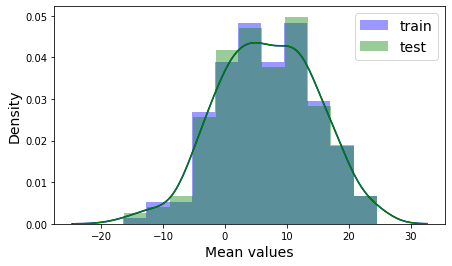

In [45]:
train_mean = train[continuous_feature].mean().values.flatten()
test_mean = test[continuous_feature].mean().values.flatten()

plt.figure(figsize=(7, 4))
sns.distplot(train_mean, color="Blue", label="train")
sns.distplot(test_mean, color="Green", label="test")

plt.xlabel('Mean values', size=14)
plt.legend(loc="best", fontsize=14)
plt.ylabel("Density", size=14)
plt.show()

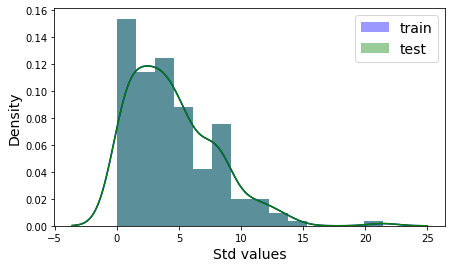

In [46]:
train_mean = train[continuous_feature].std().values.flatten()
test_mean = test[continuous_feature].std().values.flatten()

plt.figure(figsize=(7, 4))
sns.distplot(train_mean, color="Blue", label="train")
sns.distplot(test_mean, color="Green", label="test")

plt.xlabel('Std values', size=14)
plt.legend(loc="best", fontsize=14)
plt.ylabel("Density", size=14)
plt.show()

Значение средних в трейне и тесте распределены похожим образом, а STD - идентичны. 

### Задание 5: Построить распределение коэффициентов корреляции между признаками. Есть ли зависимость между признаками (будем считать, что связь между признаками отсутствует, если коэффициент корреляции < 0.2)?

In [50]:
correlation = train.corr()
corr_with_target = correlation["target"].sort_values(ascending = False)
corr_with_target

target     1.000000
var_6      0.066731
var_110    0.064275
var_53     0.063399
var_26     0.062422
             ...   
var_76    -0.061917
var_146   -0.063644
var_12    -0.069489
var_139   -0.074080
var_81    -0.080917
Name: target, Length: 201, dtype: float64

Мы видим, что значения корреляции не превышают 0.07, что не попадает в обозначенный интервал. Прямой линейной зависимости между признаками нет.

### Задание 6: Выявить 10 признаков, которые обладают наибольшей нелинейной связью с целевой переменной.

In [79]:
from sklearn.ensemble import RandomForestClassifier

%time
parameters = {"max_depth": 6, "n_estimators": 25, "random_state": 27, "n_jobs": 2}

forest = RandomForestClassifier(**parameters)
forest.fit(numerical_features.fillna(-9999).drop("target", axis=1), train["target"])

Wall time: 0 ns


RandomForestClassifier(max_depth=6, n_estimators=25, n_jobs=2, random_state=27)

Text(0.5, 1.0, 'Top 10')

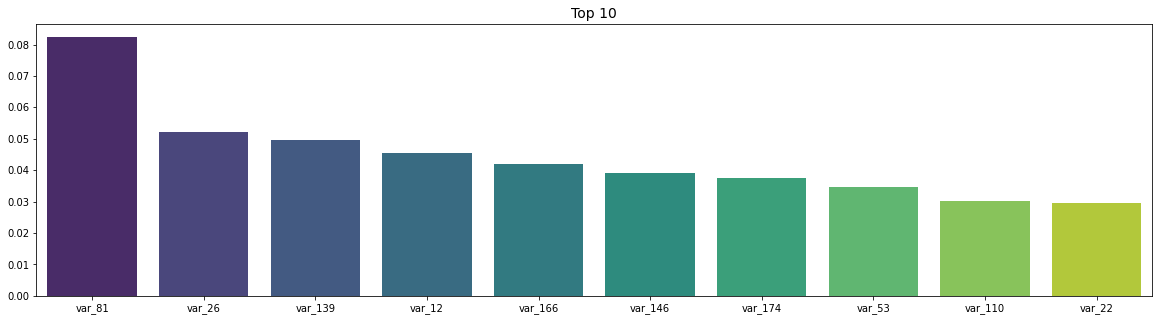

In [60]:
n_top = 10
importances = forest.feature_importances_
idx = np.argsort(importances)[::-1][0:n_top]
feature_names = numerical_features.drop("target", axis=1).columns

plt.figure(figsize=(20, 5))
sns.barplot(x=feature_names[idx], y=importances[idx], palette="viridis")
plt.title("Top 10", size=14)

In [62]:
feature_names[idx]


Index(['var_81', 'var_26', 'var_139', 'var_12', 'var_166', 'var_146',
       'var_174', 'var_53', 'var_110', 'var_22'],
      dtype='object')

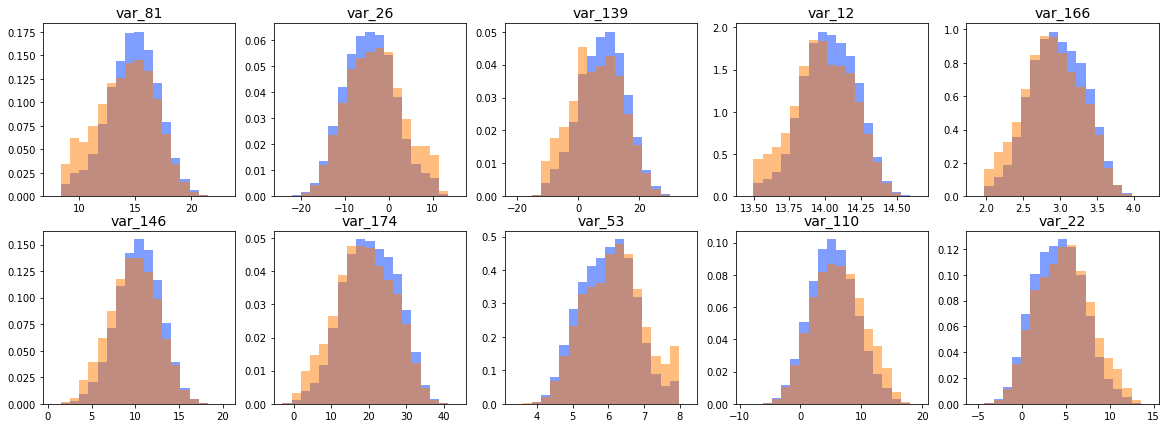

In [65]:
group = feature_names[idx].to_list()
fig, axes = plt.subplots(2, 5, figsize=(20, 7))
for num, var_name in enumerate(group):    
    var_target_0 = train.loc[train['target'] == 0, var_name]
    var_target_1 = train.loc[train['target'] == 1, var_name]    

    t1 = min(train[var_name])
    t2 = max(train[var_name])

    bins = np.linspace(t1, t2, 20)
    axes[num//5, num%5].hist(var_target_0, bins, density=True, alpha=0.5, label='No default')
    axes[num//5, num%5].hist(var_target_1, bins, density=True, alpha=0.5, label='Default')
    axes[num//5, num%5].set_title(var_name, fontsize=14)
plt.show()

### Задание 7: Провести анализ идентичности распределения признаков на обучающей и тестовой выборках, сделать выводы.


Все 10 наиболее значимых признаков имеют идентичное распределение. 


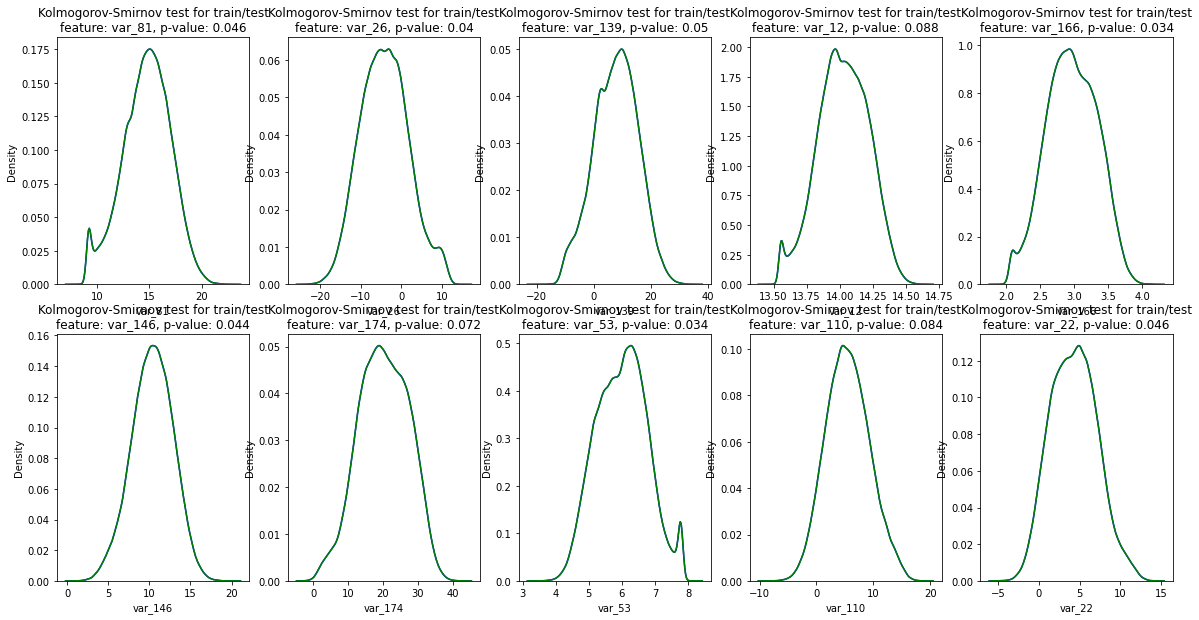

In [69]:
statistics_array = []
fig, axes = plt.subplots(2, 5, figsize=(20, 10))

for num, feature in enumerate(feature_names[idx]):
    statistic, pvalue = ks_2samp(
        train[feature].sample(500), test[feature].sample(500)
    )
    statistics_array.append(statistic)

    sns.kdeplot(train[feature], ax=axes[num//5, num%5], color="Blue", label="Train")
    sns.kdeplot(train[feature], ax=axes[num//5, num%5], color="Green", label="Test")

    axes[num//5, num%5].set_title(
        (f"Kolmogorov-Smirnov test for train/test\n"
        f"feature: {feature}, p-value: {round(statistic, 3)}")
    )

In [70]:
class PSI(BaseEstimator, TransformerMixin):
    """
    Вычисление PSI и отбор признаков на их основе.

    Parameters
    ----------
    threshold: float
        Порог для отбора переменных по PSI.
        Если PSI для переменной выше порога - переменная макрируется
        0 (не использовать для дальнейшего анализа), если ниже
        порога - маркируется 1 (использовать для дальнейшего анализа).

    categorical_features: List[str], optional, default = None
        Список категориальных признаков для анализа.
        Опциональный параметр, по умолчанию, не используется, т.е.
        категориальные признаки отсутствуют.

    n_bins: int, optional, default = 20
        Количество бинов, на которые разбивается выборка.

    min_value: float, optional, default = 0.005
        Значение которое используется, если рассчитанный psi = 0.

    bin_type: string, optional, default = "quanitles"
        Способ разбиения на бины: "quantiles" or "bins".
        При выборе "quantiles" - выборка будет разбита на n_bins
        квантилей, при выборке "bins" - выборка будет разбита на
        n_bins бакетов с равным шагом между бакетами.
        Иные значения приводят к возникновению ValueError.

    Attributes
    ----------
    scores_: Dict[str, float]
        Словарь со значениями PSI,
        ключ словаря - название признака, значение - PSI-score.

    """
    def __init__(self,
                 threshold: float,
                 categorical_features: Optional[List[str]] = None,
                 bin_type: str = "quantiles",
                 min_value: float = 0.005,
                 n_bins: int = 20):

        self.threshold = threshold
        self.categorical_features = categorical_features
        self.min_value = min_value
        self.n_bins = n_bins
        if bin_type in ["quantiles", "bins"]:
            self.bin_type = bin_type
        else:
            raise ValueError(
                "Incorrect bin_type value. Expected 'quantiles' or 'bins', "
                f"but {bin_type} is transferred."
            )
        self.scores = {}

    def calculate_bins(self, data: pd.Series) -> np.array:
        """
        Вычисление границ бинов для разбиения выборки.

        Parameters
        ----------
        data: pandas.Series, shape = [n_samples, ]
            наблюдения из train-выборки.

        Returns
        -------
        bins: numpy.array, shape = [self.n_bins + 1]
            Список с границами бинов.

        """
        if self.bin_type == "quantiles":
            bins = np.linspace(0, 100, self.n_bins + 1)
            bins = [np.nanpercentile(data, x) for x in bins]

        else:
            bins = np.linspace(data.min(), data.max(), self.n_bins + 1)

        return np.unique(bins)

    def calculate_psi_in_bin(self, expected_score, actual_score) -> float:
        """
        Вычисление значения psi для одного бакета.

        Осуществляется проверка на равенство нулю expected_score и
        actual_score: если один из аргументов равен нулю, то его
        значение заменяется на self.min_value.

        Parameters
        ----------
        expected_score: float
            Ожидаемое значение.

        actual_score: float
            Наблюдаемое значение.

        Returns
        -------
        value: float
            Значение psi в бине.

        """
        if expected_score == 0:
            expected_score = self.min_value
        if actual_score == 0:
            actual_score = self.min_value

        value = (expected_score - actual_score)
        value = value * np.log(expected_score / actual_score)

        return value

    def calculate_psi(self, expected: pd.Series, actual: pd.Series, bins) -> float:
        """
        Расчет PSI для одной переменной.

        Parameters
        ----------
        expected: pandas.Series, shape = [n_samples_e, ]
            Наблюдения из train-выборки.

        actual: pandas.Series, shape = [n_samples_o, ]
            Наблюдения из test-выборки.

        bins: pandas.Series, shape = [self.n_bins, ]
            Бины для расчета PSI.

        Returns
        -------
        psi_score: float
            PSI-значение для данной пары выборок.

        """
        expected_score = np.histogram(expected.fillna(-9999), bins)[0]
        expected_score = expected_score / expected.shape[0]

        actual_score = np.histogram(actual.fillna(-9999), bins)[0]
        actual_score = actual_score / actual.shape[0]

        psi_score = np.sum(
            self.calculate_psi_in_bin(exp_score, act_score)
            for exp_score, act_score in zip(expected_score, actual_score)
        )

        return psi_score

    def calculate_numeric_psi(self, expected: pd.Series, actual: pd.Series) -> float:
        """
        Вычисление PSI для числовой переменной.

        Parameters
        ----------
        expected: pandas.Series, shape = [n_samples_e, ]
            Наблюдения из train-выборки.

        actual: pandas.Series, shape = [n_samples_o, ]
            Наблюдения из test-выборки.

        Returns
        -------
        psi_score: float
            PSI-значение для данной пары выборок.

        """
        bins = self.calculate_bins(expected)
        psi_score = self.calculate_psi(expected, actual, bins)
        return psi_score

    def calculate_categorical_psi(self, expected: pd.Series, actual: pd.Series) -> float:
        """
        Вычисление PSI для категориальной переменной.
        PSI рассчитывается для каждого уникального значения категории.

        Parameters
        ----------
        expected: pandas.Series, shape = [n_samples_e, ]
            Наблюдения из train-выборки.

        actual: pandas.Series, shape = [n_samples_o, ]
            Наблюдения из test-выборки.

        Returns
        -------
        psi_score: float
            PSI-значение для данной пары выборок.

        """
        bins = np.unique(expected).tolist()
        psi_score = self.calculate_psi(expected, actual, bins)
        return psi_score

    def fit(self, X, y=None):
        """
        Вычисление PSI-значения для всех признаков.

        Parameters
        ----------
        X: pandas.DataFrame, shape = [n_samples, n_features]
            Матрица признаков для обучения.

        y: pandas.DataFrame, shape = [n_samples, n_features]
            Матрица признаков для тестирования.

        Returns
        -------
        self
        """
        missed_columns = list(set(X.columns) - set(y.columns))

        if missed_columns:
            raise MissedColumnError(
                f"Missed {list(missed_columns)} columns in data.")

        if self.categorical_features:
            numeric_features = list(
                set(X.columns) - set(self.categorical_features)
            )
            for feature in self.categorical_features:
                self.scores[feature] = self.calculate_categorical_psi(
                    X[feature], y[feature]
                )
        else:
            numeric_features = X.columns

        for feature in tqdm(numeric_features):
            self.scores[feature] = self.calculate_numeric_psi(
                X[feature], y[feature]
            )
        return self

    def transform(self, X, y=None) -> pd.DataFrame:
        """
        Отбор переменных по self.threshold.
        Если PSI-score для переменной выше порога, то переменная
        помечается 0 (не использовать для дальнейшего анализа), если ниже
        порога - маркируется 1 (использовать для дальнейшего анализа).

        Parameters
        ----------
        data: pandas.DataFrame, shape = [n_samples, n_features]
            Матрица признаков для обучения.

        target: pandas.DataFrame, shape = [n_samples, n_features]
            Матрица признаков для тестирования.

        Returns
        -------
        scores: pandas.DataFrame, shape = [n_features, 3]
            Датафрейм с PSI-анализом переменных.

        """
        check_is_fitted(self, "scores")
        scores = pd.Series(self.scores)
        scores = pd.DataFrame({"Variable": scores.index, "PSI": scores.values})
        scores["Selected"] = np.where(scores.PSI < self.threshold, 1, 0)
        scores = scores.sort_values(by="PSI")

        mask = scores["Selected"] == 1
        self.used_features = scores.loc[mask, "Variable"].tolist()

        return scores.reset_index(drop=True)

In [72]:
features_to_score = numerical_features.drop(["target"], axis=1).columns.tolist()
psi = PSI(threshold=0.01)

In [73]:
psi.fit_transform(
    X=train[features_to_score],
    y=test[features_to_score]
)

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:13<00:00, 15.25it/s]


,Variable,PSI,Selected
0,var_154,0.000085,1
1,var_156,0.000132,1
2,var_5,0.000138,1
3,var_148,0.000150,1
4,var_35,0.000151,1
...,...,...,...
195,var_124,0.000615,1
196,var_79,0.000628,1
197,var_162,0.000639,1
198,var_29,0.000667,1


In [74]:
X_adv = pd.concat([
    train[features_to_score], test[features_to_score]
])
y_adv = np.hstack(
    (np.ones(train.shape[0]), np.zeros(test.shape[0])))

X_adv = X_adv.reset_index(drop=True)

In [75]:
%%time
parameters = {"max_depth": 4, "n_estimators": 50, "random_state": 27, "n_jobs": 2}
model = xgb.XGBClassifier(**parameters)

cv = cross_val_score(
    estimator=model,
    X=X_adv, y=y_adv,
    scoring="roc_auc",
    cv=KFold(n_splits=3, shuffle=True, random_state=27)
)

print(f"CV-score: {round(np.mean(cv), 4)}")

CV-score: 0.5116
Wall time: 4min 42s


Text(0.5, 1.0, 'Top Importance Features for Adversarial Validation (train vs test)')

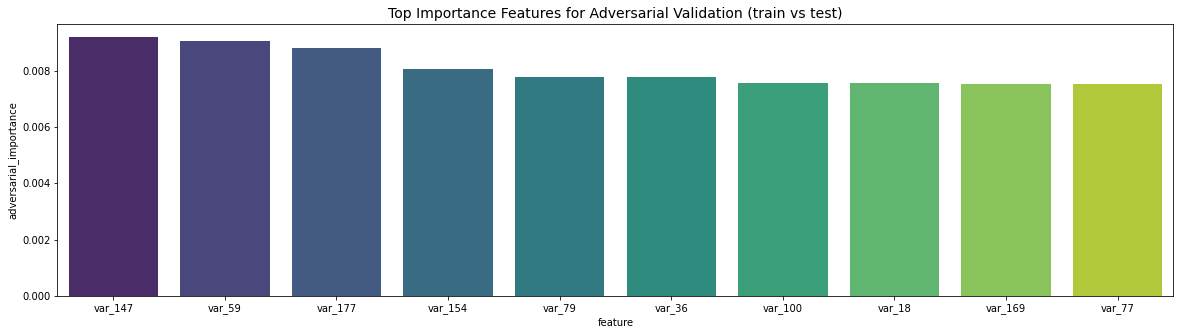

In [80]:
model.fit(X_adv, y_adv)

importance = pd.DataFrame({
    "feature": X_adv.columns,
    "adversarial_importance": model.feature_importances_
})
importance = importance.sort_values(by="adversarial_importance", ascending=False)
importance = importance.head(n=10)

plt.figure(figsize=(20, 5))
sns.barplot(x=importance["feature"], y=importance["adversarial_importance"], palette="viridis")
plt.title("Top Importance Features for Adversarial Validation (train vs test)", size=14)